<a href="https://colab.research.google.com/github/isaacmenchaca97/breast_cancer_detection/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Data preparation
# ========================================================================
import pandas as pd
import numpy as np
from scipy import stats

# Graph
# ========================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('ggplot')

# MLFlow
# ========================================================================
import mlflow
import mlflow.sklearn
import dagshub

# Sklearn
# ========================================================================
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model Performance Evaluators
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report


### Loading the data

In [3]:
data = load_breast_cancer()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Exploratory Data Analysis aka EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_radius              569 non-null    float64
 1   mean_texture             569 non-null    float64
 2   mean_perimeter           569 non-null    float64
 3   mean_area                569 non-null    float64
 4   mean_smoothness          569 non-null    float64
 5   mean_compactness         569 non-null    float64
 6   mean_concavity           569 non-null    float64
 7   mean_concave_points      569 non-null    float64
 8   mean_symmetry            569 non-null    float64
 9   mean_fractal_dimension   569 non-null    float64
 10  radius_error             569 non-null    float64
 11  texture_error            569 non-null    float64
 12  perimeter_error          569 non-null    float64
 13  area_error               569 non-null    float64
 14  smoothness_error         5

In [5]:
df.dtypes.value_counts()

float64    30
int64       1
Name: count, dtype: int64

In [6]:
df[df.columns].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean_texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean_perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean_area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean_smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean_compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean_concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean_concave_points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean_symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean_fractal_dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


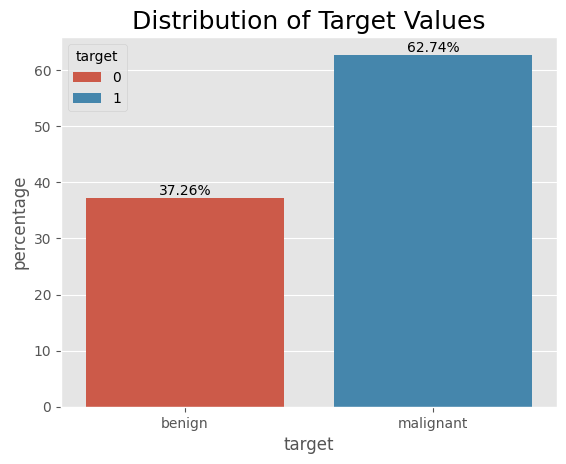

In [7]:
value_counts_df = (round(df.target.value_counts(normalize=True)*100,2)).reset_index()
value_counts_df.columns = ['target', 'percentage']
ax = sns.barplot(x=value_counts_df['target'], y=value_counts_df['percentage'], hue=value_counts_df['target'], dodge=False)
ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.bar_label(ax.containers[1],fmt="%.2f%%")
plt.xticks(ticks=[0,1], labels=['benign', 'malignant'])
plt.title('Distribution of Target Values', fontsize=18)
plt.show()

In [8]:
num_cols = list(df.select_dtypes('float64').columns)
unrelated_num_cols = []
categorical_col = 'target'

for i in num_cols:
    # Perform Kruskal-Wallis test
    grouped_data = [df[i][df[categorical_col] == category] for category in df[categorical_col].unique()]
    statistic, p_value = stats.f_oneway(*grouped_data)

    # Set the significance level (alpha)
    alpha = 0.05

    # Print the results with appropriate text color
    if p_value < alpha:
        print( f"ANOVA statistic: {round(statistic, 2)}")
        print(f"p-value: {p_value:.2e}")
        print("\033[32m" + f"Reject the null hypothesis: There is a significant relationship between {i} and {categorical_col}")
        print("\033[0m")  # Reset text color to default
    else:
        print( f"ANOVA statistic: {round(statistic, 2)}")
        print(f"p-value: {p_value:.2e}")
        print("\033[31m" + f"No significant relationship between {i} and {categorical_col}")
        print("\033[0m")  # Reset text color to default
        unrelated_num_cols.append(i)

ANOVA statistic: 646.98
p-value: 8.47e-96
Reject the null hypothesis: There is a significant relationship between mean_radius and target

ANOVA statistic: 118.1
p-value: 4.06e-25
Reject the null hypothesis: There is a significant relationship between mean_texture and target

ANOVA statistic: 697.24
p-value: 8.44e-101
Reject the null hypothesis: There is a significant relationship between mean_perimeter and target

ANOVA statistic: 573.06
p-value: 4.73e-88
Reject the null hypothesis: There is a significant relationship between mean_area and target

ANOVA statistic: 83.65
p-value: 1.05e-18
Reject the null hypothesis: There is a significant relationship between mean_smoothness and target

ANOVA statistic: 313.23
p-value: 3.94e-56
Reject the null hypothesis: There is a significant relationship between mean_compactness and target

ANOVA statistic: 533.79
p-value: 9.97e-84
Reject the null hypothesis: There is a significant relationship between mean_concavity and target

ANOVA statistic: 861.

In [9]:
print(f'The columns that failed the ANOVA test are {unrelated_num_cols}. These columns don\'t help in making predictions.')

The columns that failed the ANOVA test are ['mean_fractal_dimension', 'texture_error', 'smoothness_error', 'symmetry_error', 'fractal_dimension_error']. These columns don't help in making predictions.


### Data Pre-processing

In [ ]:
df = df.drop(labels=unrelated_num_cols, axis=1)
df.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'radius_error',
       'perimeter_error', 'area_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'worst_radius', 'worst_texture',
       'worst_perimeter', 'worst_area', 'worst_smoothness',
       'worst_compactness', 'worst_concavity', 'worst_concave_points',
       'worst_symmetry', 'worst_fractal_dimension', 'target'],
      dtype='object')

In [11]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
print('X_train Shape -',X_train.shape,',', 'y_train Shape -', y_train.shape)
print('X_test shape -', X_test.shape,',','y_test shape -', y_test.shape)

X_train Shape - (455, 25) , y_train Shape - (455,)
X_test shape - (114, 25) , y_test shape - (114,)


### Principal Component Analysis (PCA)

In [ ]:
pca_pipe = make_pipeline(MinMaxScaler(), PCA(random_state=42), memory=None)
pca_pipe.fit(X)

# Se extrae el modelo entrenado del pipeline
model_pca = pca_pipe.named_steps['pca']

In [14]:
prop_varianza_acum = model_pca.explained_variance_ratio_.cumsum()
n_pca = 0
for i in range(model_pca.n_components_):
    if prop_varianza_acum[i]*100 < 92:
        n_pca += 1
        print(f'At {n_pca} PC, Explained Variance is {round(prop_varianza_acum[i]*100,2)}%')

At 1 PC, Explained Variance is 59.5%
At 2 PC, Explained Variance is 74.83%
At 3 PC, Explained Variance is 82.28%
At 4 PC, Explained Variance is 87.3%
At 5 PC, Explained Variance is 90.77%


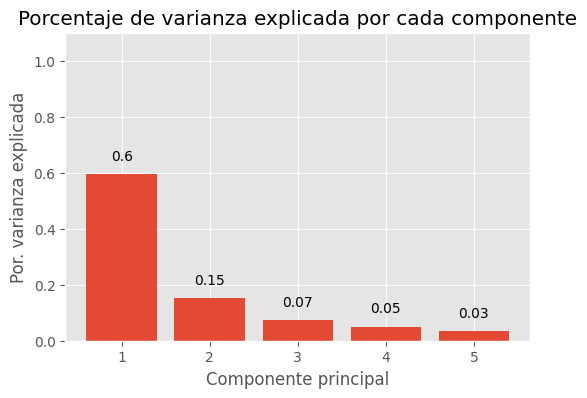

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(n_pca) + 1,
    height = model_pca.explained_variance_ratio_[:n_pca],
)

for x, y_axis in zip(np.arange(n_pca) + 1, model_pca.explained_variance_ratio_[:n_pca]):
    label = round(y_axis, 2)
    ax.annotate(
        label,
        (x,y_axis),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(n_pca) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');


[0.59501941 0.74834484 0.82281042 0.87302617 0.90773815 0.93463044
 0.94988493 0.96079605 0.97080502 0.97756904 0.98223264 0.98576041
 0.98901659 0.99175811 0.99406284 0.99597394 0.99714047 0.99808642
 0.99874701 0.99923814 0.99963744 0.99989128 0.99995833 0.99999314
 1.        ]


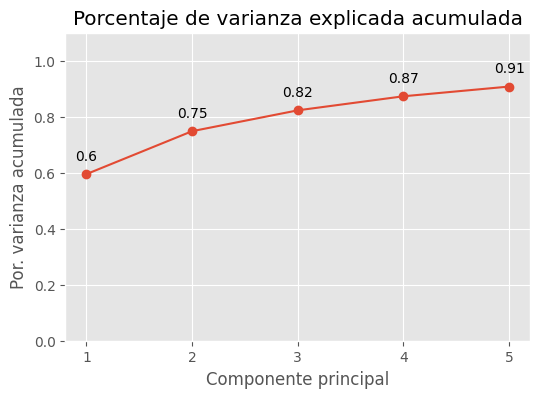

In [16]:
prop_varianza_acum = model_pca.explained_variance_ratio_.cumsum()
print(prop_varianza_acum)

n_pca = 0
for i in range(model_pca.n_components_):
    if prop_varianza_acum[i]*100 < 92:
        n_pca += 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(n_pca) + 1,
    prop_varianza_acum[:n_pca],
    marker = 'o'
)

for x, y_axis in zip(np.arange(n_pca) + 1, prop_varianza_acum[:n_pca]):
    label = round(y_axis, 2)
    ax.annotate(
        label,
        (x,y_axis),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(n_pca) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');


### Handling class imbalance

In [17]:
label, counts = np.unique(y, return_counts=True)
print(f"label: {label}\ncounts: {counts}")
# compute the class weights
counts = max(counts) / counts
class_weights = dict(zip(label, np.around(counts,3)))
print('=== CLASS WEIGHTS ===')
print(class_weights)

label: [0 1]
counts: [212 357]
=== CLASS WEIGHTS ===
{np.int64(0): np.float64(1.684), np.int64(1): np.float64(1.0)}


### Select model k-Fold Cross validation

In [ ]:
#Creating a list of classifier models
names = ['Logistic Regression', "KNN", "Linear SVM","Gradient Boosting", "Decision Tree", "Random Forest"]
classifiers = [
    LogisticRegression(solver='liblinear', class_weight=class_weights, random_state=42),
    KNeighborsClassifier(n_neighbors=3, weights= 'distance'),
    SVC(kernel="linear", C=0.025, class_weight=class_weights, gamma='scale', random_state=42),
    GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42),
    DecisionTreeClassifier(ccp_alpha=0, max_depth=5, class_weight=class_weights, random_state=42),
    RandomForestClassifier(min_samples_leaf=1, max_features="sqrt", max_depth=5, n_estimators=100, class_weight=class_weights, random_state=42)
    ]

In [19]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)

# Define the number of folds for cross-validation
num_folds = 5  # You can adjust this as needed

# Initialize an empty list to store scores
scores = []

for name, clf in zip(names, classifiers):
    # Perform k-fold cross-validation and calculate the mean score
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=num_folds)
    mean_score = np.mean(cv_scores)
    scores.append(mean_score)

# Create a DataFrame to store the results
scores_df = pd.DataFrame()
scores_df['Name'] = names
scores_df['CV Mean score'] = np.around(scores, 3)

# Sort the DataFrame by score in descending order
sorted_scores_df = scores_df.sort_values('CV Mean score', ascending=False)
sorted_scores_df

,Name,CV Mean score
0,Logistic Regression,0.976
3,Gradient Boosting,0.956
5,Random Forest,0.956
1,KNN,0.954
2,Linear SVM,0.938
4,Decision Tree,0.910


### Model accuracy and performance check

In [ ]:
import dagshub
dagshub.init(repo_owner='isaacmenchaca97', repo_name='breast_cancer_detection', mlflow=True)

In [ ]:
mlflow.sklearn.autolog()
mlflow.set_experiment("Breast Cancer Classification")

with mlflow.start_run():
    model_pipeline = make_pipeline(
        MinMaxScaler(),
        PCA(n_components=n_pca, random_state=42),
        LogisticRegression(solver='liblinear', class_weight=class_weights, random_state=42),
        memory=None
        )

    model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=5)),
                ('logisticregression',
                 LogisticRegression(class_weight={np.int64(0): np.float64(1.684),
                                                  np.int64(1): np.float64(1.0)},
                                    random_state=42, solver='liblinear'))])

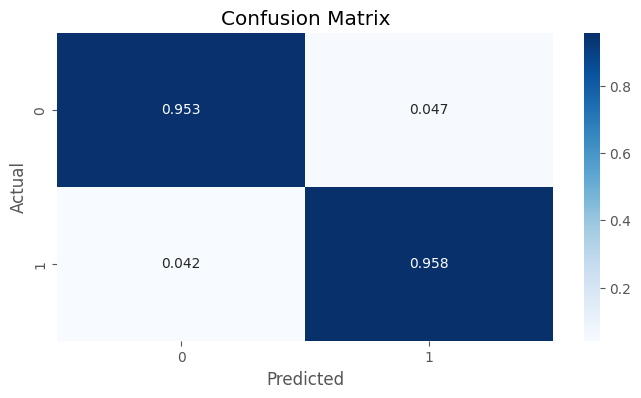

In [ ]:
#making the predictions
y_pred = model_pipeline.predict(X_test)

#Creating the confusion matrix
confusionmatrix = np.around(confusion_matrix(y_test, y_pred, normalize='true'),3)

#Plotting the Confusion Matrix
plt.figure(figsize=(8, 4))
sns.heatmap(confusionmatrix, annot=True, fmt='.3g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("DataBase/confusion_matrix.png")

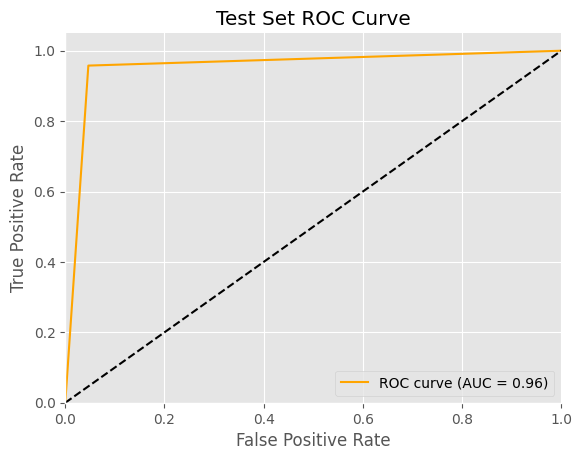

In [34]:
# Assuming you have your model predictions and true labels
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc), color='orange')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc="lower right")
plt.savefig("DataBase/roc_curve.png")
plt.show()

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [24]:
misclassified_count = np.sum(y_test != y_pred)
total_cases = len(y_test)
error_rate = np.around((misclassified_count / total_cases) * 100, 3)

print(f"{misclassified_count} out of {total_cases} cases were misclassified, Error rate : {error_rate}%.")

5 out of 114 cases were misclassified, Error rate : 4.386%.


### MLFlow

In [ ]:
import dagshub
dagshub.init(repo_owner='isaacmenchaca97', repo_name='breast_cancer_detection', mlflow=True)

In [32]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [35]:
mlflow.set_experiment("Breast Cancer Classification")

with mlflow.start_run():
  # Register parameters
  mlflow.log_param("n_components", n_pca)
  mlflow.log_param("solver", "liblinear")

  # Register metrics
  mlflow.log_metric("Accuracy", accuracy)
  mlflow.log_metric("Precision", precision)
  mlflow.log_metric("Recall", recall)
  mlflow.log_metric("F1 Score", f1)
  mlflow.log_metric("ROC AUC", roc_auc)

  # Load graphics
  mlflow.log_artifact("DataBase/confusion_matrix.png")
  mlflow.log_artifact("DataBase/roc_curve.png")

  # Register model
  mlflow.sklearn.log_model(model_pipeline, "model_cancer_classification", input_example=X_train.iloc[:2])

/Users/isaacmenchacapanecatl/Documents/breast_cancer_detection/.venv/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
